In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pure_ldp.frequency_oracles.direct_encoding import DEClient
from pure_ldp.frequency_oracles.local_hashing import LHClient
from pure_ldp.frequency_oracles.rappor import RAPPORClient, RAPPORServer
from pure_ldp.core import generate_hash
from pure_ldp.core.prob_simplex import project_probability_simplex
import random
import sys
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso

In [6]:
# Cargar datos
data_path = '../data/raw/bank-full.csv'
df = pd.read_csv(data_path, sep=';')
df['y'] = df['y'].map({'no': 0, 'yes': 1})
X = df.drop(columns=['y'])
y = df['y']

# Mejores parámetros encontrados
best_params_rf = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

In [7]:
# Función para mapear variables categóricas binarias y meses
def map_binary_columns(df):
    df['default'] = df['default'].map({'no': 0, 'yes': 1})
    df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
    df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
    df['month'] = df['month'].map({
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    })
    return df

# Función para convertir variables numéricas en categóricas
def convert_numerics_to_categories(df):
    # age
    bins_age = [18, 30, 40, 50, 60, 95]
    labels_age = ['18-30', '31-40', '41-50', '51-60', '61+']
    df['age'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, include_lowest=True)

    # balance
    bins_balance = [-8019, 0, 72, 448, 1428, 102127]
    labels_balance = ['negative', '0-72', '73-448', '449-1428', '1429+']
    df['balance'] = pd.cut(df['balance'], bins=bins_balance, labels=labels_balance, include_lowest=True)

    # day
    bins_day = [1, 7, 14, 21, 31]
    labels_day = ['1-7', '8-14', '15-21', '22-31']
    df['day'] = pd.cut(df['day'], bins=bins_day, labels=labels_day, include_lowest=True)

    # duration
    bins_duration = [0, 103, 180, 319, 4918]
    labels_duration = ['0-103', '104-180', '181-319', '320+']
    df['duration'] = pd.cut(df['duration'], bins=bins_duration, labels=labels_duration, include_lowest=True)

    # campaign
    bins_campaign = [1, 2, 3, 10, 63]
    labels_campaign = ['1', '2-3', '4-10', '11+']
    df['campaign'] = pd.cut(df['campaign'], bins=bins_campaign, labels=labels_campaign, include_lowest=True)

    # pdays
    bins_pdays = [-1, 0, 30, 90, 871]
    labels_pdays = ['no_contact', '0-30', '31-90', '91+']
    df['pdays'] = pd.cut(df['pdays'], bins=bins_pdays, labels=labels_pdays, include_lowest=True)

    # previous
    bins_previous = [0, 1, 2, 5, 275]
    labels_previous = ['0', '1-2', '3-5', '6+']
    df['previous'] = pd.cut(df['previous'], bins=bins_previous, labels=labels_previous, include_lowest=True)

    return df

# Función para mapear variables categóricas a valores numéricos
def map_categorical_columns(df, categorical_columns):
    mappings = {}
    for col in categorical_columns:
        unique_values = df[col].unique()
        mappings[col] = {value: idx for idx, value in enumerate(unique_values) if pd.notna(value)}
        df[col] = df[col].map(mappings[col])
    return df, mappings

# Funciones para aplicar DE, OLH y RAPPOR
def apply_de(df, epsilon, categorical_columns):
    df_de = df.copy()
    for col in categorical_columns:
        de = DEClient(epsilon=epsilon, d=df[col].nunique())
        df_de[col] = df_de[col].apply(lambda x: de.privatise(int(x)))
    return df_de

def apply_olh(df, epsilon, categorical_columns):
    df_olh = df.copy()
    for col in categorical_columns:
        d = df[col].nunique()
        olh = LHClient(epsilon=epsilon, d=d, use_olh=True)
        df_olh[col] = df_olh[col].apply(lambda x: olh.privatise(int(x))[0] % d)
    return df_olh

# Subclase para corregir _perturb en RAPPOR
class FixedRAPPORClient(RAPPORClient):
    def _perturb(self, data):
        perturbed_data = data.copy()
        for i, bit in enumerate(perturbed_data):
            u = random.random()
            if bit == 1:
                if u < 0.5 * self.f:
                    perturbed_data[i] = 0
            else:
                if u < 0.5 * self.f:
                    perturbed_data[i] = 1
        return perturbed_data

# Subclase para aumentar max_iter en RAPPORServer
class FixedRAPPORServer(RAPPORServer):
    def _update_estimates(self):
        y = self._create_y()
        X = self._create_X()
        if self.reg_const == 0:
            model = LinearRegression(positive=True, fit_intercept=False)
        else:
            model = ElasticNet(positive=True, alpha=self.reg_const,
                               l1_ratio=0, fit_intercept=False,
                               max_iter=100000)
        if self.d > 1000 or self.lasso:
            lasso_model = Lasso(alpha=0.8, positive=True)
            lasso_model.fit(X, y)
            indexes = np.nonzero(lasso_model.coef_)[0]
            X_red = X[:, indexes]
            model.fit(X_red, y)
            self.estimated_data[indexes] = model.coef_ * self.num_of_cohorts
        else:
            model.fit(X, y)
            self.estimated_data = model.coef_ * self.num_of_cohorts

def apply_rappor(df, epsilon, categorical_columns):
    x = df.copy()
    for col in categorical_columns:
        d = x[col].nunique()
        m = 128
        k = 2
        num_of_cohorts = 8
        temp_client = FixedRAPPORClient(f=0.5, m=m, hash_funcs=[[]])
        f = temp_client.convert_eps_to_f(epsilon)
        hash_funcs = []
        for i in range(num_of_cohorts):
            cohort_hashes = [generate_hash(m, random.randint(0, sys.maxsize)) for _ in range(k)]
            hash_funcs.append(cohort_hashes)
        rappor_client = FixedRAPPORClient(f=f, m=m, hash_funcs=hash_funcs, num_of_cohorts=num_of_cohorts)
        rappor_server = FixedRAPPORServer(f=f, m=m, k=k, d=d, num_of_cohorts=num_of_cohorts)
        bit_vectors = []
        for i in range(len(x)):
            value = int(x[col].iloc[i])
            bv = rappor_client.privatise(value)
            bit_vectors.append(bv)
        for bv in bit_vectors:
            rappor_server.aggregate(bv)
        freqs = {}
        for i in range(d):
            freqs[i] = max(rappor_server.estimate(i), 0)
        freqs_array = np.array([freqs[i] for i in range(d)])
        normalized_freqs = project_probability_simplex(freqs_array)
        mapping = {i: normalized_freqs[i] for i in range(d)}
        x[col] = x[col].map(mapping)
    return x

# Procesamiento completo
def process_data(X, y, categorical_columns, method='none', epsilon=None):
    x = X.copy()
    if method == 'de' and epsilon:
        x = apply_de(x, epsilon, categorical_columns)
    elif method == 'olh' and epsilon:
        x = apply_olh(x, epsilon, categorical_columns)
    elif method == 'rappor' and epsilon:
        x = apply_rappor(x, epsilon, categorical_columns)
    
    # One-Hot Encoding (OHE)
    x = pd.get_dummies(x, columns=categorical_columns, drop_first=True, dtype='int64')

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # No se necesita escalado porque todas las columnas son categóricas

    # Aplicar SMOTEENN para balancear clases
    smoteenn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

    # Selección de características con Boruta
    rf = RandomForestClassifier(**best_params_rf, random_state=42)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=0)
    boruta.fit(X_train_resampled.values, y_train_resampled.values)
    selected_features = X_train_resampled.columns[boruta.support_].tolist()
    return X_train_resampled[selected_features], X_test[selected_features], y_train_resampled, y_test

# Entrenar y evaluar modelo
def evaluate_model(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(**best_params_rf, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    conf_matrix = confusion_matrix(y_test, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_pct = conf_matrix[0][1] / actual_negatives if actual_negatives > 0 else 0
    false_negative_pct = conf_matrix[1][0] / actual_positives if actual_positives > 0 else 0
    return {
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Type I Error': false_positive_pct,
        'Type II Error': false_negative_pct
    }

In [8]:
# Todas las columnas son ahora categóricas
all_categorical_columns = ['default', 'housing', 'loan', 'job', 'marital', 'education', 'contact', 'poutcome',
                           'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Epsilons y resultados
epsilons = [5, 1, 0.5, 0.1]
results_de = {}
results_olh = {}
results_rappor = {}

In [9]:
# Preprocesar datos originales
X = map_binary_columns(X)
X = convert_numerics_to_categories(X)
X, cat_mappings = map_categorical_columns(X, all_categorical_columns)

In [10]:
# Modelo sin privacidad
X_train, X_test, y_train, y_test = process_data(X, y, all_categorical_columns, method='none')
results_de['Original'] = evaluate_model(X_train, y_train, X_test, y_test)
results_olh['Original'] = results_de['Original']
results_rappor['Original'] = results_de['Original']

In [ ]:
for epsilon in epsilons:
    # Modelos con Direct Encoding
    X_train_de, X_test_de, y_train_de, y_test_de = process_data(X, y, all_categorical_columns, method='de', epsilon=epsilon)
    results_de[f'DE (ε={epsilon})'] = evaluate_model(X_train_de, y_train_de, X_test_de, y_test_de)
    
    # Modelos con OLH
    X_train_olh, X_test_olh, y_train_olh, y_test_olh = process_data(X, y, all_categorical_columns, method='olh', epsilon=epsilon)
    results_olh[f'OLH (ε={epsilon})'] = evaluate_model(X_train_olh, y_train_olh, X_test_olh, y_test_olh)

    # Modelos con RAPPOR
    X_train_rappor, X_test_rappor, y_train_rappor, y_test_rappor = process_data(X, y, all_categorical_columns, method='rappor', epsilon=epsilon)
    results_rappor[f'RAPPOR (ε={epsilon})'] = evaluate_model(X_train_rappor, y_train_rappor, X_test_rappor, y_test_rappor)

# Resultados
results_de_df = pd.DataFrame(results_de)
results_olh_df = pd.DataFrame(results_olh)
results_rappor_df = pd.DataFrame(results_rappor)

c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+08, tolerance: 2.599e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e+08, tolerance: 3.

Resultados DE:
                Original  DE (ε=5)  DE (ε=1)  DE (ε=0.5)  DE (ε=0.1)
ROC AUC        0.852700  0.849973  0.807346    0.842035    0.801479
Accuracy       0.759216  0.750590  0.625774    0.664922    0.568121
Precision      0.307123  0.301092  0.224231    0.247039    0.204331
Recall         0.831039  0.845432  0.884856    0.900501    0.921151
F1 Score       0.448497  0.444043  0.357794    0.387714    0.334469
Type I Error   0.250376  0.262076  0.408825    0.366539    0.479024
Type II Error  0.168961  0.154568  0.115144    0.099499    0.078849

Resultados OLH:
                Original  OLH (ε=5)  OLH (ε=1)  OLH (ε=0.5)  OLH (ε=0.1)
ROC AUC        0.852700   0.806201   0.717374     0.809308     0.727494
Accuracy       0.759216   0.581908   0.494839     0.661236     0.528974
Precision      0.307123   0.208196   0.169643     0.237336     0.179703
Recall         0.831039   0.909262   0.844180     0.847309     0.841051
F1 Score       0.448497   0.338813   0.282513     0.370807    

In [14]:
print("Resultados DE:")
results_de_df

Resultados DE:


,Original,DE (ε=5),DE (ε=1),DE (ε=0.5),DE (ε=0.1)
ROC AUC,0.852700,0.849973,0.807346,0.842035,0.801479
Accuracy,0.759216,0.750590,0.625774,0.664922,0.568121
Precision,0.307123,0.301092,0.224231,0.247039,0.204331
Recall,0.831039,0.845432,0.884856,0.900501,0.921151
F1 Score,0.448497,0.444043,0.357794,0.387714,0.334469
Type I Error,0.250376,0.262076,0.408825,0.366539,0.479024
Type II Error,0.168961,0.154568,0.115144,0.099499,0.078849


In [15]:
print("\nResultados OLH:")
results_olh_df


Resultados OLH:


,Original,OLH (ε=5),OLH (ε=1),OLH (ε=0.5),OLH (ε=0.1)
ROC AUC,0.852700,0.806201,0.717374,0.809308,0.727494
Accuracy,0.759216,0.581908,0.494839,0.661236,0.528974
Precision,0.307123,0.208196,0.169643,0.237336,0.179703
Recall,0.831039,0.909262,0.844180,0.847309,0.841051
F1 Score,0.448497,0.338813,0.282513,0.370807,0.296133
Type I Error,0.250376,0.461808,0.551813,0.363614,0.512703
Type II Error,0.168961,0.090738,0.155820,0.152691,0.158949


In [16]:
print("\nResultados RAPPOR:")
results_rappor_df


Resultados RAPPOR:


,Original,RAPPOR (ε=5),RAPPOR (ε=1),RAPPOR (ε=0.5),RAPPOR (ε=0.1)
ROC AUC,0.852700,0.703864,0.683026,0.842557,0.771505
Accuracy,0.759216,0.682100,0.876364,0.848643,0.702890
Precision,0.307123,0.200442,0.462128,0.393142,0.234961
Recall,0.831039,0.568210,0.301627,0.523780,0.674593
F1 Score,0.448497,0.296345,0.365013,0.449155,0.348529
Type I Error,0.250376,0.302691,0.046883,0.107973,0.293331
Type II Error,0.168961,0.431790,0.698373,0.476220,0.325407


<Figure size 1200x600 with 0 Axes>

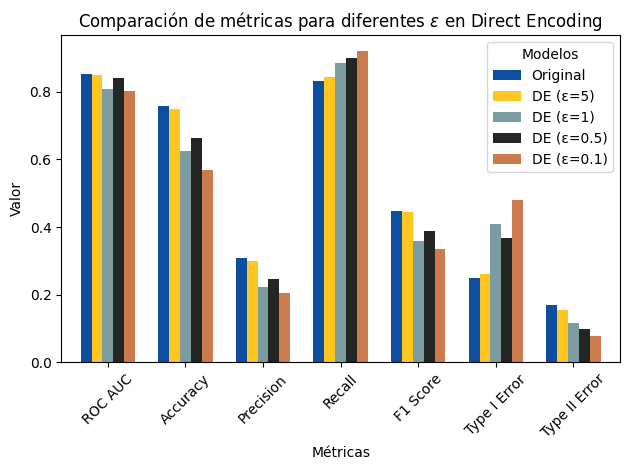

<Figure size 1200x600 with 0 Axes>

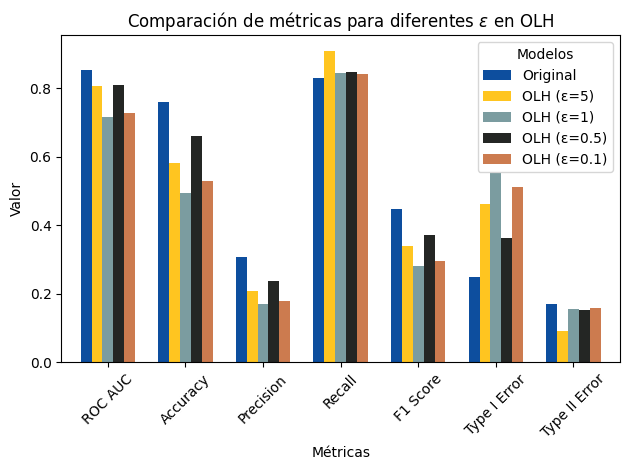

<Figure size 1200x600 with 0 Axes>

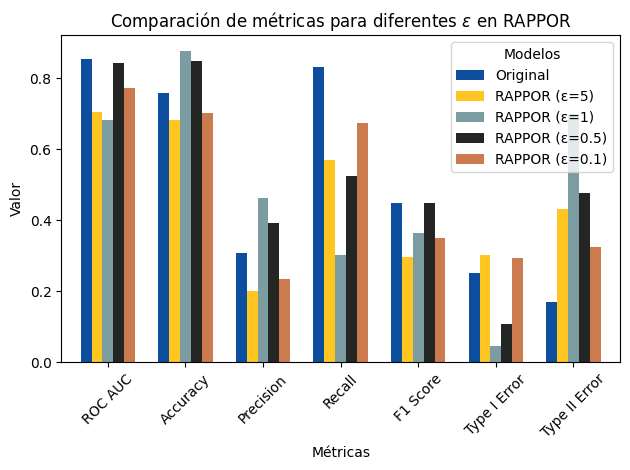

In [12]:
### Gráficas
colores = ['#0d4e9e', '#ffc520', '#7b9ca0', '#242624', '#cc7b4f']

def plot_results(results_df, title):
    plt.figure(figsize=(12, 6))
    ax = results_df.plot(kind='bar', width=0.7, color=colores)
    plt.title(title)
    plt.xlabel('Métricas')
    plt.ylabel('Valor')
    plt.xticks(rotation=45)
    plt.legend(title='Modelos')
    plt.tight_layout()
    plt.show()

plot_results(results_de_df, 'Comparación de métricas para diferentes $\epsilon$ en Direct Encoding')
plot_results(results_olh_df, 'Comparación de métricas para diferentes $\epsilon$ en OLH')
plot_results(results_rappor_df, 'Comparación de métricas para diferentes $\epsilon$ en RAPPOR')